## **Project Context and Motivation**

Digital image processing (DIP) forms the foundation of many computer vision applications, long before the rise of machine learning. 
This project revisits classical approaches to image analysis and classification through a real-world use case: traffic sign classification.

### **Importing Libraries**

In [1]:
import os
import sys
import random
import numpy as np 
import cv2
import matplotlib.pyplot as plt
sys.path.append('Image_processing/') 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import preprocessing as pr
import colour_and_segmentation as cs
import edge_detection as ed
import geometric as gm
import feature_extraction as fe
from rule_based_classification import classify_road_sign

In [2]:
## data directories 
base_dir = 'Data'

# Paths constructed using os.path.join for cross-platform compatibility
data_dir = os.path.join(base_dir, 'Train.csv')
# test_dir = os.path.join(base_dir, 'Train')
filtered_data_dir = os.path.join(base_dir, 'filtered_data.csv')
compiled_original_images_dir = 'images_by_label.npy' ## path to the compiled original images directory

### **Class selection and image reading**

In [27]:
data_csv = np.genfromtxt(data_dir, delimiter=',', dtype=None, encoding=None) # read the csv file
data_csv[:1]

array([['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2',
        'ClassId', 'Path']], dtype='<U30')

In [8]:
data_csv

In [29]:
#we are just using 6 unique classes for this 

column_7 = data_csv[:, 6] # get the 7th column of the csv file
unique_classes = np.unique(column_7) # get the unique classes in the 7th column

print("Unique classes in the 7th column: ", unique_classes) # print the unique classes

Unique classes in the 7th column:  ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9' 'ClassId']


run these lines to select different random classes to run the script on otherwise, keep them commented

In [30]:
# # randomly select 6 unique classes from the unique classes
# selected_classes = random.sample(list(unique_classes), 6) # select 6 unique classes

In [31]:
# selected_classes

In [32]:
# ##saving the selected classes to a text file
# with open('selected_classes.txt', 'w') as f:
#     for item in selected_classes:
#         f.write("%s\n" % item)

In [33]:
selected_classes_path = os.path.join('Data', 'selected_classes.txt')
selected_classes = np.genfromtxt(selected_classes_path, dtype=str)

In [34]:
selected_classes 

array(['33', '26', '24', '9', '0', '4'], dtype='<U2')

In [35]:
# filter the data to only include the selected classes
filtered_data = data_csv[np.isin(data_csv[:, 6], selected_classes)] 
# removing the header row 
filtered_data = filtered_data[1:] 

In [36]:
np.unique(filtered_data[:,6]) # additional check to see if the filtered data has the selected classes

array(['0', '24', '26', '33', '4', '9'], dtype='<U30')

In [9]:
# we only need class ID and image path for the filtered data
filtered_data = filtered_data[:, -2:]
for row in filtered_data:
    print('\t'.join(row))

**Limiting the Data to only 100 images per class**

In [38]:
limited_data = []
header, rows = data_csv[0], data_csv[1:]
filtered_rows = rows[np.isin(rows[:, 6], selected_classes)]

for cls in selected_classes:
    class_rows = filtered_rows[filtered_rows[:, 6] == cls]
    limited_data.append(class_rows[:100])

limited_data = np.vstack(limited_data)  # combine into one array
limited_data = limited_data[:, -2:]     # take only last two columns

print(f"Limited Data Shape:\n{limited_data.shape}")


Limited Data Shape:
(600, 2)


## **Preprocessing the images**

In [3]:
def read_csv(file_path, base_dir=''):
    data = np.genfromtxt(file_path, delimiter=',', dtype=None, encoding='utf-8-sig')

    # Dictionary to store images grouped by label
    images_by_label = {}

    for row in data[1:]:  # Skip header
        label = row[0]
        image_path = os.path.normpath(row[1])  # Normalize the path
        full_image_path = os.path.normpath(os.path.join(base_dir, image_path))
        #print(full_image_path, os.path.exists(full_image_path))
        if label not in images_by_label:
            images_by_label[label] = []

        images_by_label[label].append({
            "path": image_path,
            "image": cv2.imread(full_image_path)
        })
    return images_by_label

In [4]:
images = read_csv(filtered_data_dir)
# np.save('images_by_label.npy', images) # save the original compiled images to a numpy file

In [22]:
## applying the filter to the images 
filters = {
    'mean': pr.mean_filter,
    'gaussian': lambda img: pr.gaussian_filter(img, sigma=1.0),
    'median': pr.median_filter,
    'adaptive_median': pr.adaptive_median_filter,
    'unsharp': pr.unsharp_mask
}
processed_images = {}

for label, image_list in images.items():
    processed_images[label] = {}
    for filter_name, filter_fn in filters.items():
        processed_images[label][filter_name] = []  # list of processed images
        for entry in image_list:
            original_img = entry['image']
            filtered_img = filter_fn(original_img)
            processed_images[label][filter_name].append({
                'path': entry['path'],
                'filtered_image': filtered_img
            })

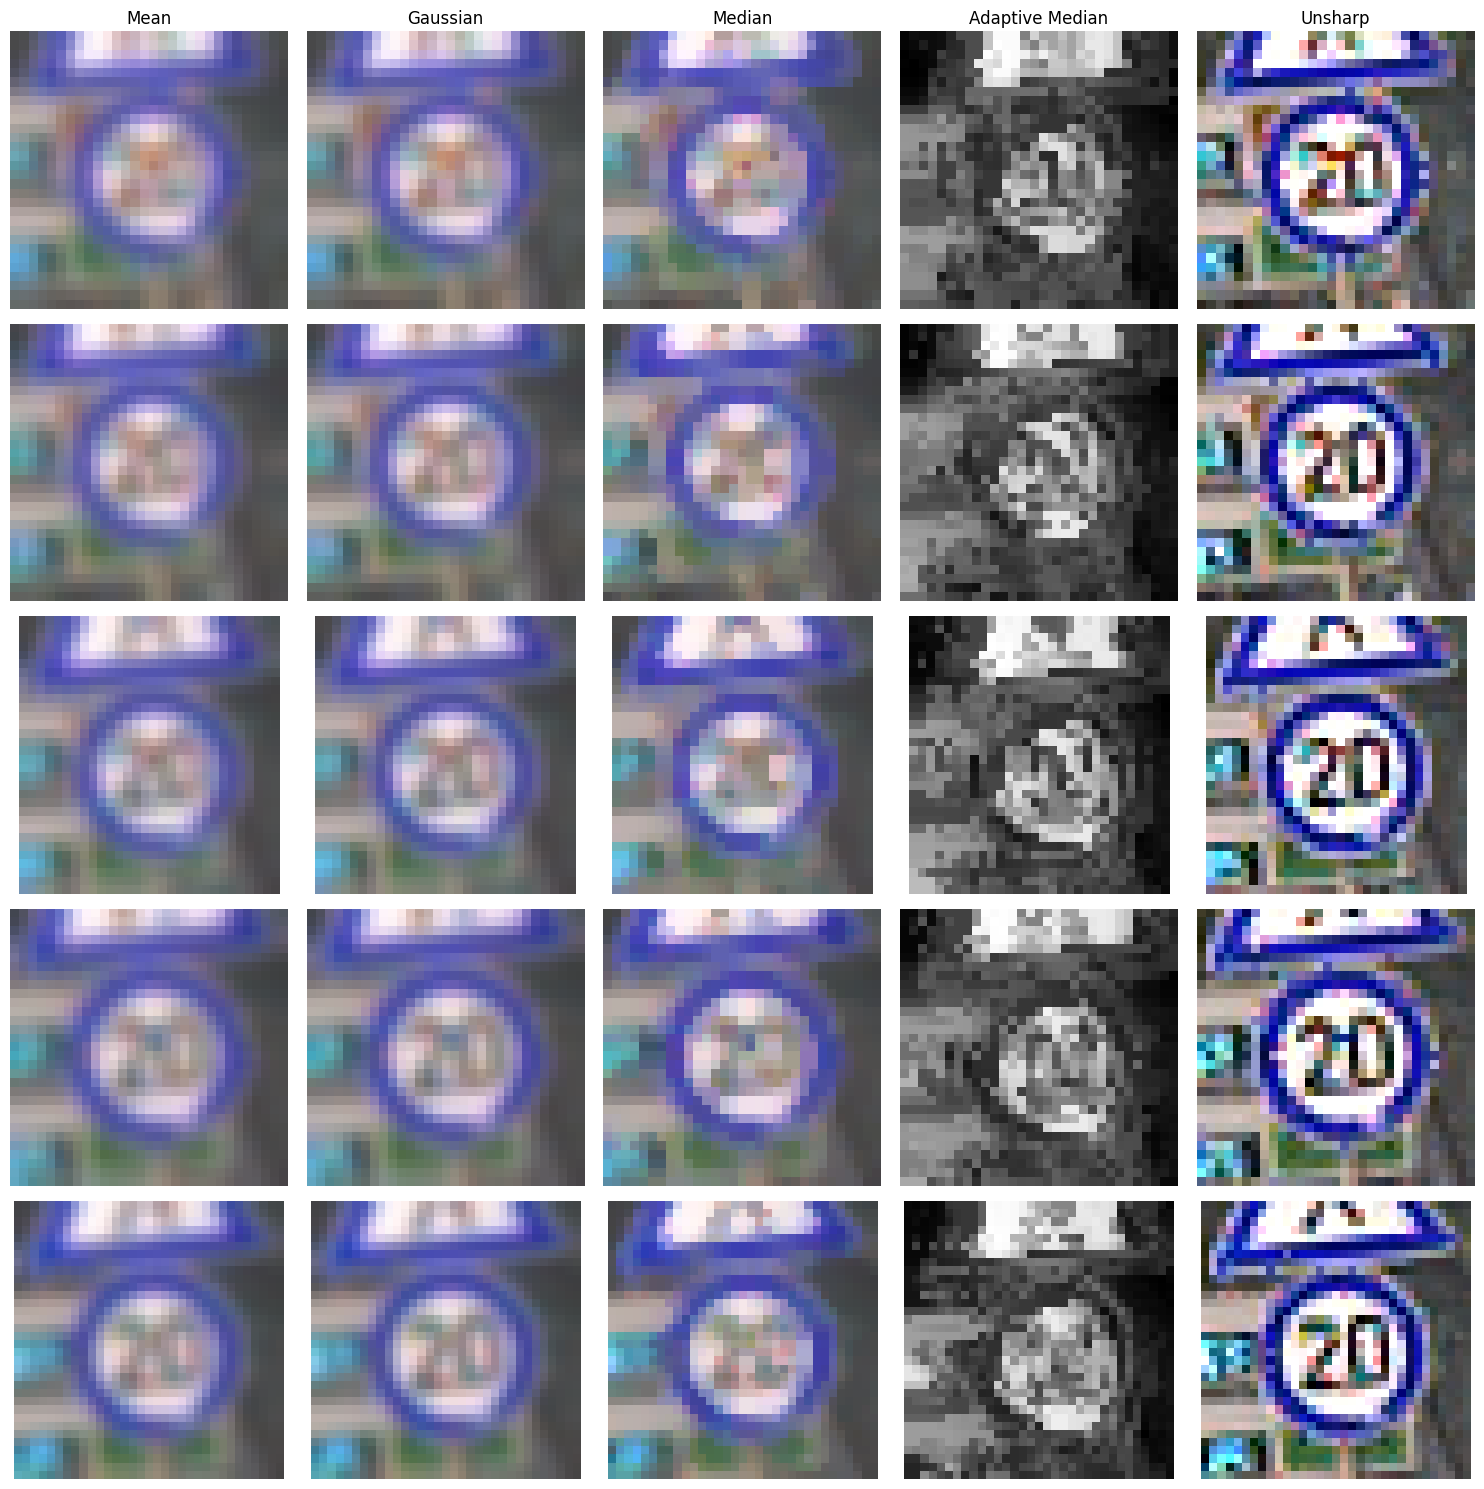

In [ ]:
label = 0  # Class label (string if your dictionary uses strings as keys)
sample_indices = [0, 1, 2, 3, 4]  # Example: show first 5 images of class '0'
filter_names = ['mean', 'gaussian', 'median', 'adaptive_median', 'unsharp']

rows = len(sample_indices)
cols = len(filter_names)

plt.figure(figsize=(cols * 3.5, rows * 3.5))

for row_idx, img_idx in enumerate(sample_indices):
    for col_idx, fname in enumerate(filter_names):
        filtered_img = processed_images[label][fname][img_idx]['filtered_image']
        image_path = processed_images[label][fname][img_idx]['path']
        image_name = image_path.split('/')[-1]  # Get just the filename

        plt_idx = row_idx * cols + col_idx + 1
        plt.subplot(rows, cols, plt_idx)

        # Handle RGB or grayscale
        if filtered_img.ndim == 3 and filtered_img.shape[2] == 3:
            plt.imshow(filtered_img.astype(np.uint8))
        else:
            plt.imshow(filtered_img, cmap='gray')

        # Titles for top row
        if row_idx == 0:
            plt.title(fname.replace('_', ' ').title(), fontsize=10)

        # Labels for bottom of each subplot
        plt.xlabel(f"Image {img_idx} – {image_name}", fontsize=8)
        plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.show()

In [5]:
import os
import cv2
import numpy as np
import preprocessing as pr
import colour_and_segmentation as cs
import edge_detection as ed
import geometric as gm

images = read_csv(filtered_data_dir)

# --- Filters from preprocessing.py ---
filters = {
    'mean': lambda img: pr.mean_filter(image=img),  
    'gaussian': lambda img: pr.gaussian_filter(image=img, sigma=1.0),  
    'median': lambda img: pr.median_filter(image=img, kernel_size=3),  
    'adaptive_median': lambda img: pr.adaptive_median_filter(img=img),  
    'unsharp': lambda img: pr.unsharp_mask(img=img) 
}

# --- Colour and segmentation filters ---
color_ops = {
    'grayscale': cs.rgb_to_grayscale,
    'hsv': cs.rgb_to_hsv,
    'segment_red': cs.segment_red,
    'segment_blue': cs.segment_blue,
    'segment_traffic_sign': cs.segment_traffic_sign,
    'opened_mask': lambda img: cs.morphological_operations(img, operation='opening'),
    'traffic_sign_complete': lambda img: cs.fill_holes(
        cs.connected_component_filtering(
            cs.morphological_operations(
                cs.segment_traffic_sign(cs.rgb_to_hsv(img)),
                operation='opening'
            ),
            min_area=100
        )
    ),
    'filled_mask': lambda img: cs.fill_holes(
        cs.segment_traffic_sign(cs.rgb_to_hsv(img))  # Convert RGB image to binary mask first
    )
}

# --- Edge detection operations ---
edge_ops = {
    'sobel': lambda img: ed.sobel_operator(pr.gaussian_filter(cs.rgb_to_grayscale(img)))[0],  # return only magnitude
    'canny': ed.canny_edge_detection
}

# --- Geometric operations ---
geometric_ops = {
    'rotate_30': lambda img: gm.rotate_image(img, 30),
    'scale_half': lambda img: gm.scale_image_by_factor(img, 0.5, 0.5),
    'normalize': lambda img: gm.geometric_normalization(img, angle=15, target_size=(200, 200), apply_perspective=True)
}

# --- Combine all processing steps ---
all_operations = {
    **filters,
    **color_ops,
    **edge_ops,
    **geometric_ops
}

# --- Process and store ---
processed_images = {}
for label, image_list in images.items():
    processed_images[label] = {}
    for op_name, op_fn in all_operations.items():
        processed_images[label][op_name] = []
        for entry in image_list:
            img = entry['image']
            if img is None:
                print(f"Skipping {entry['path']} (image not found)")
                continue
            try:
                result = op_fn(img)
                processed_images[label][op_name].append({
                    'path': entry['path'],
                    'filtered_image': result
                })
            except Exception as e:
                print(f"Error applying {op_name} to {entry['path']}: {e}")

# Optionally: Save to .npy or write images to disk
# np.save('processed_images_all.npy', processed_images)

In [6]:
import matplotlib.pyplot as plt

def visualize_processed_images(processed_images, max_images=5):
    """
    Visualize the first 'max_images' images for every operation.
    """
    for operation in processed_images[next(iter(processed_images))].keys():
        fig, axes = plt.subplots(1, max_images, figsize=(15, 3))
        fig.suptitle(f'Operation: {operation}', fontsize=16)

        shown = 0
        for label, op_dict in processed_images.items():
            if operation not in op_dict:
                continue
            for item in op_dict[operation]:
                if shown >= max_images:
                    break
                img = item['filtered_image']
                # Convert BGR to RGB for matplotlib display
                if len(img.shape) == 3:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                else:
                    img_rgb = img
                axes[shown].imshow(img_rgb, cmap='gray' if len(img.shape) == 2 else None)
                axes[shown].axis('off')
                axes[shown].set_title(f"{label}")
                shown += 1
            if shown >= max_images:
                break

        # Fill remaining axes if any
        for i in range(shown, max_images):
            axes[i].axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

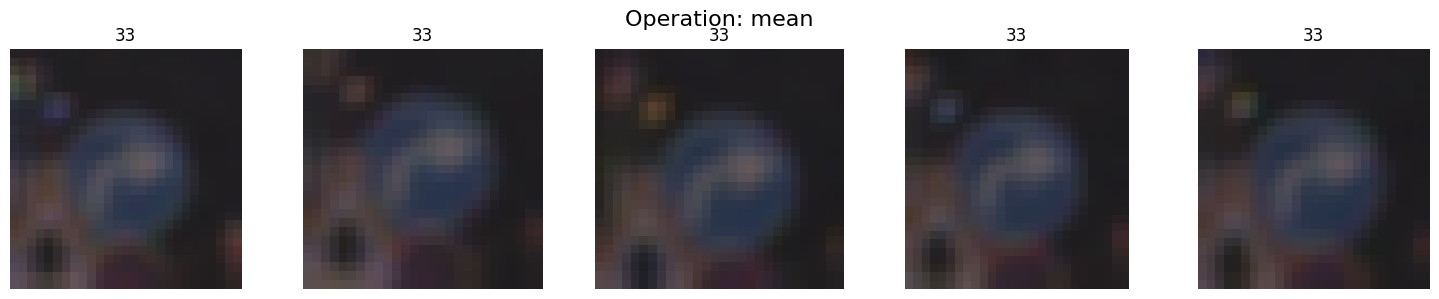

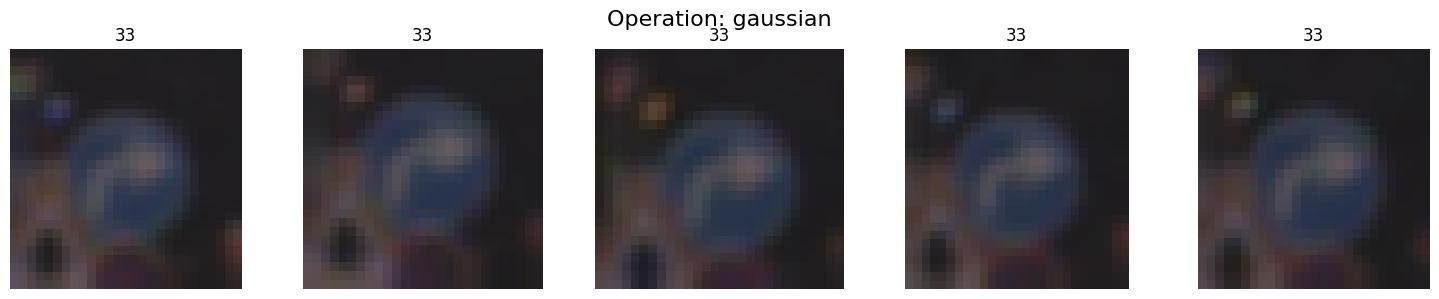

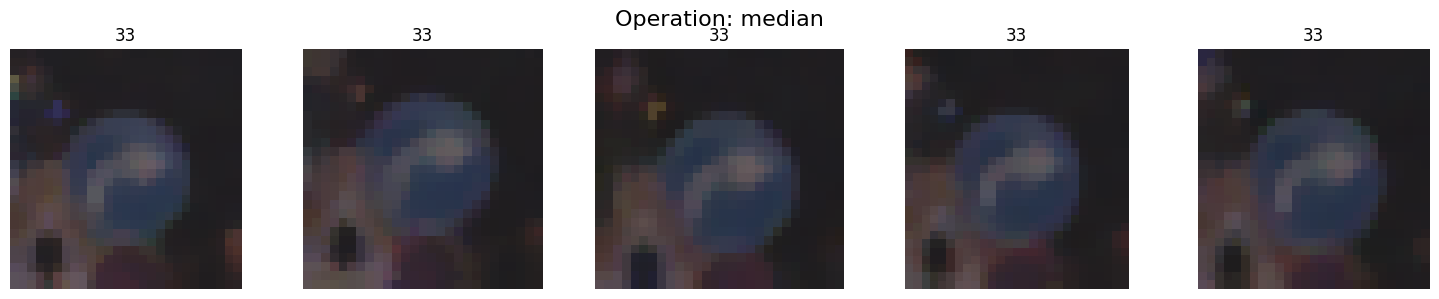

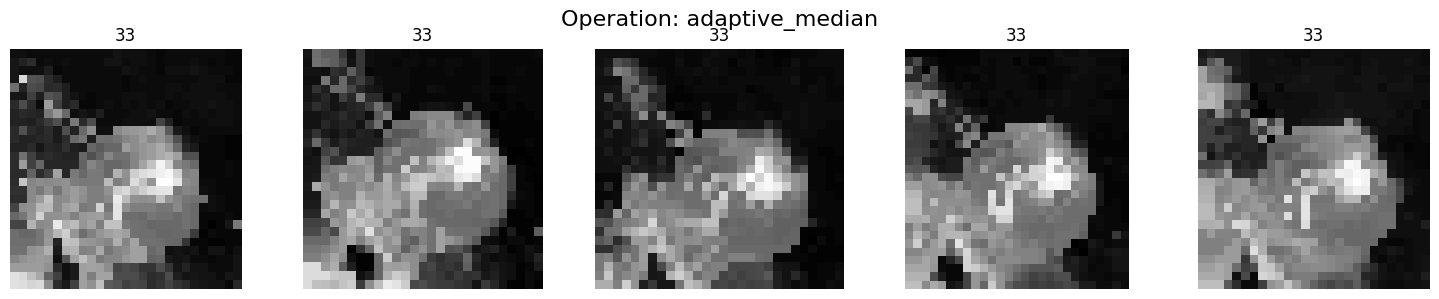

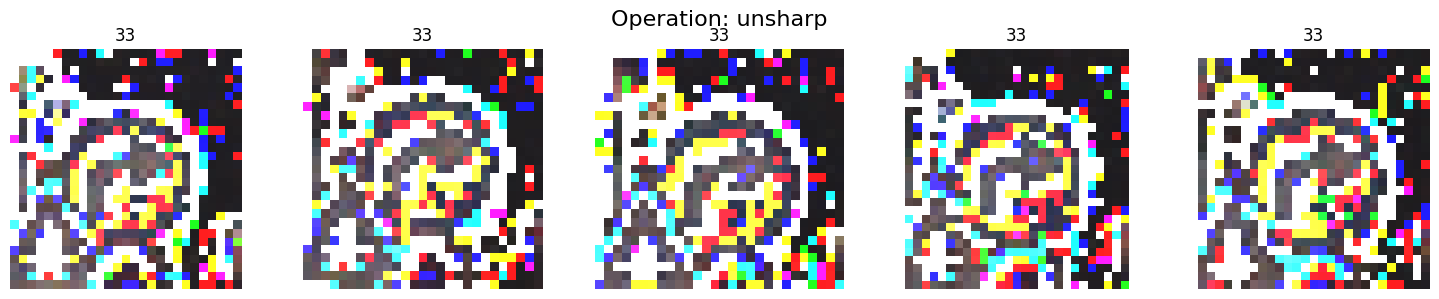

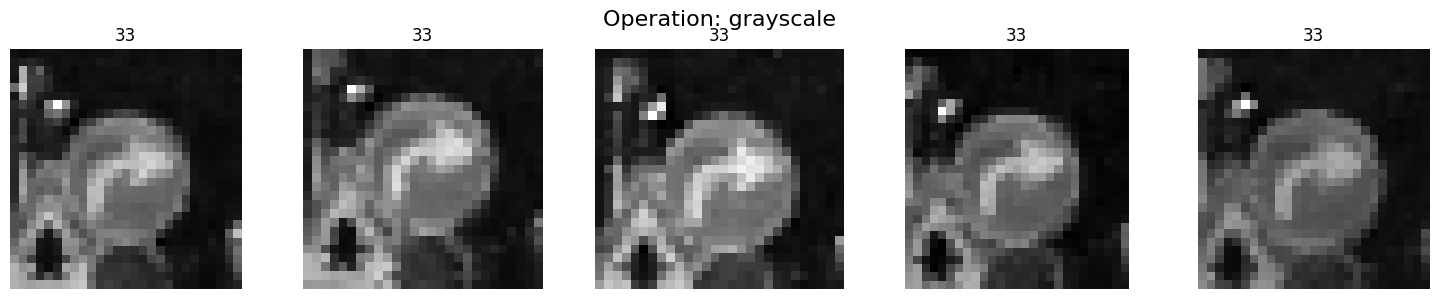

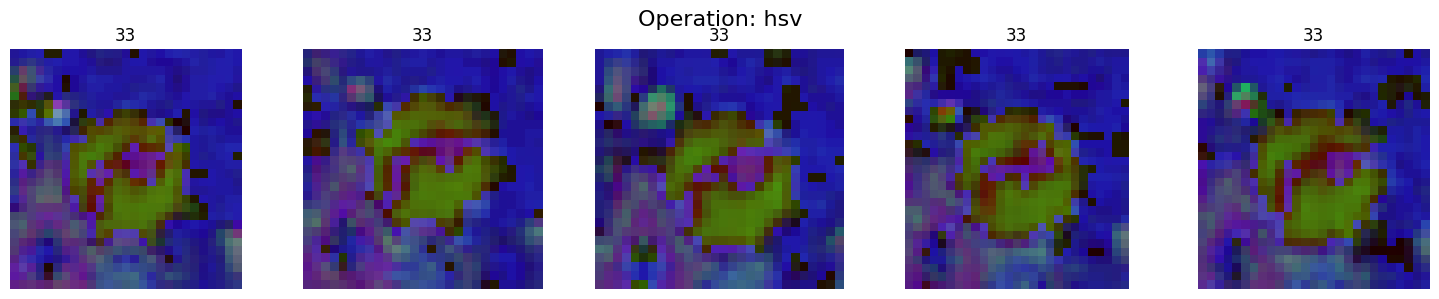

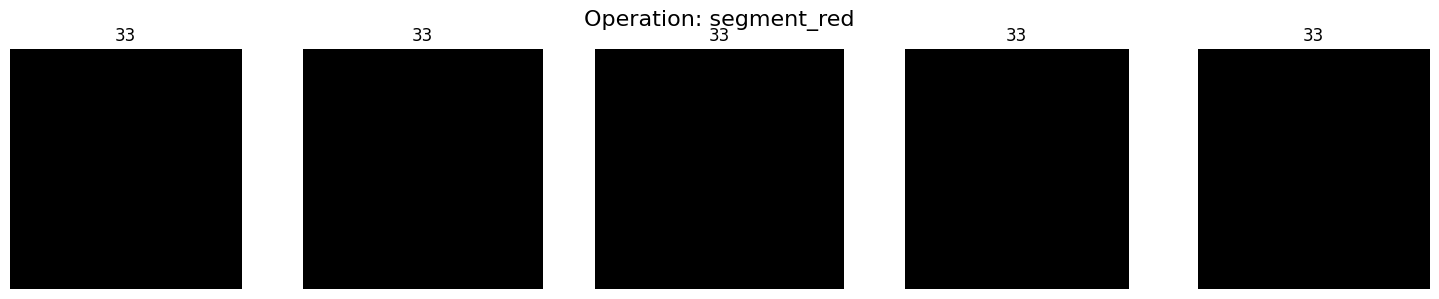

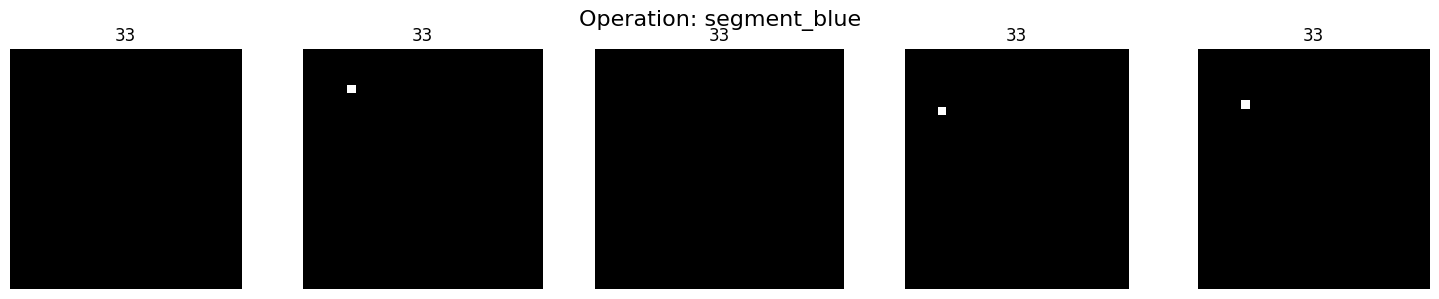

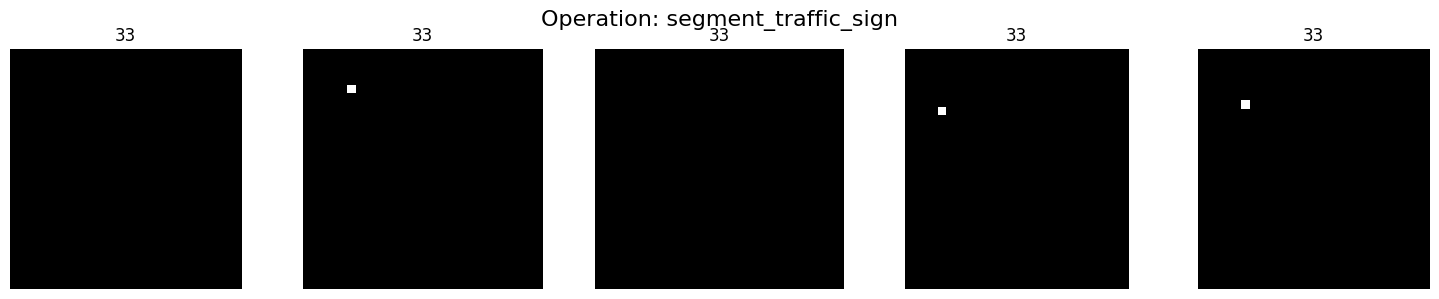

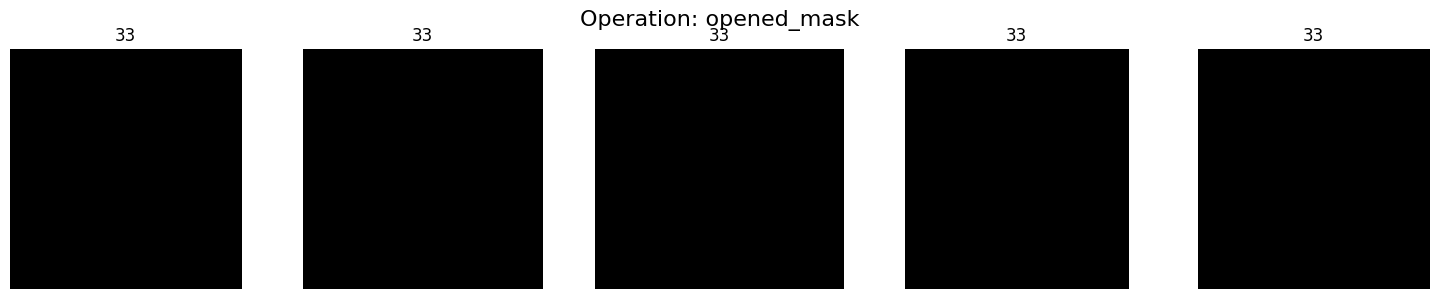

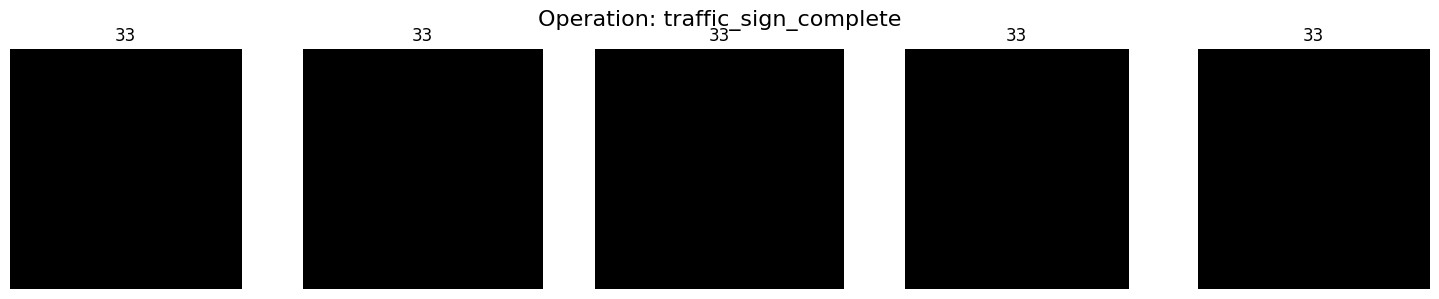

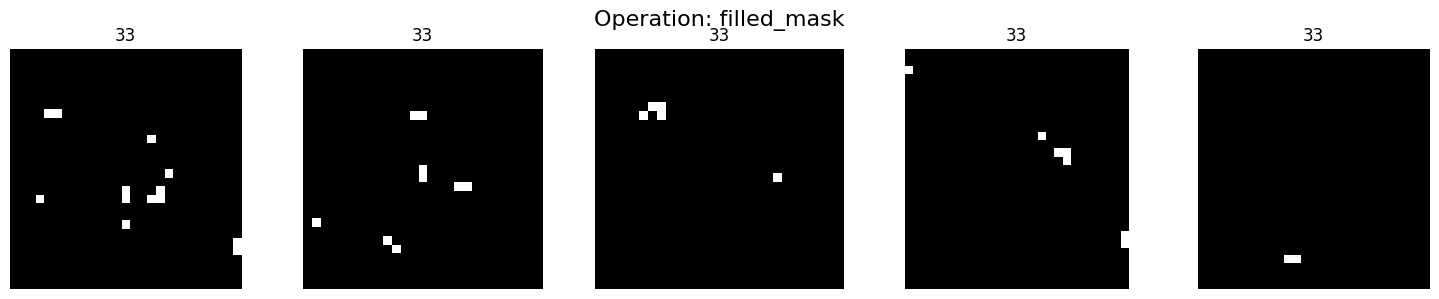

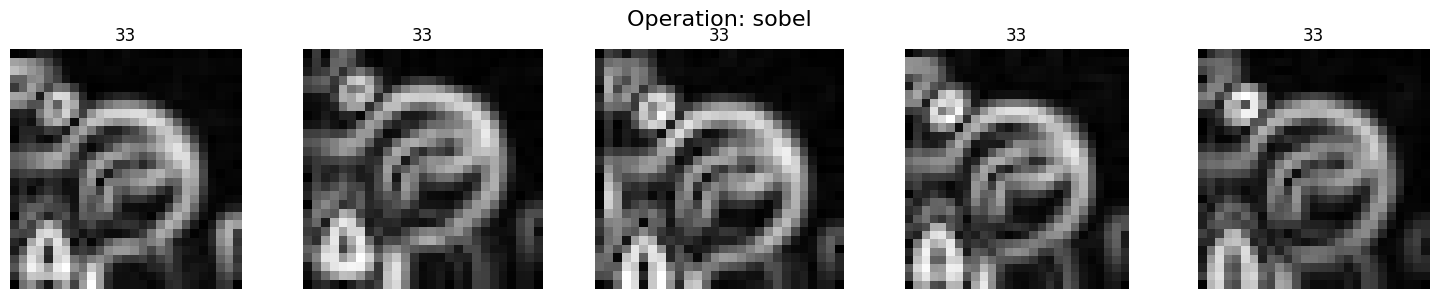

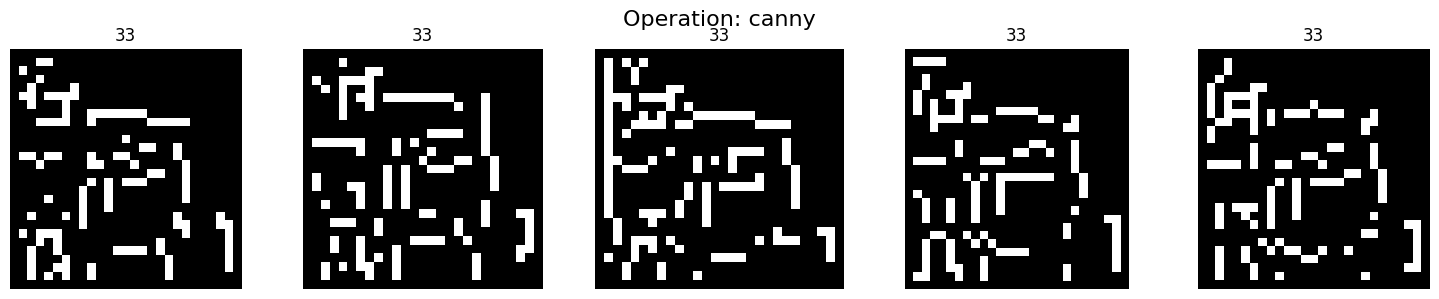

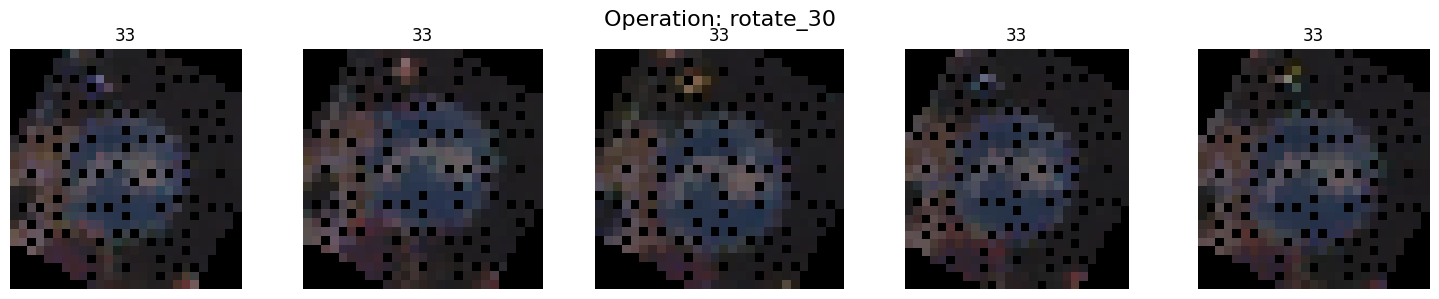

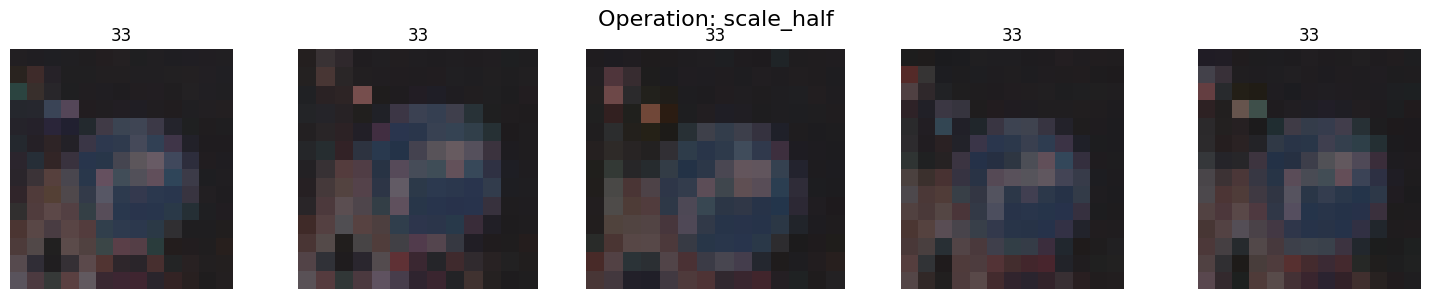

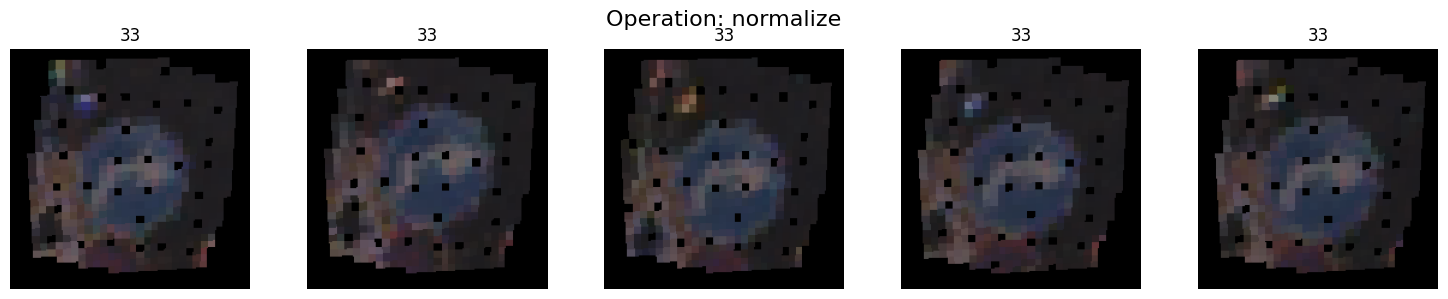

In [7]:
visualize_processed_images(processed_images, max_images=5)

In [ ]:
np.save('processed_images_all.npy', processed_images)

## **Testing**

In [ ]:
# Function to read data from csv
def read_csv(csv_path):
    """
    Read the filtered CSV file containing ClassId and ImagePath
    Args:
        csv_path: Path to CSV file
    Returns:
        Dictionary mapping class IDs to lists of image information
    """
    # Read the CSV file
    df = pd.read_csv(csv_path, header=None, names=['ClassId', 'Path'])
    
    # Create a dictionary to store images by class
    images_by_class = {}
    
    # Group images by class
    for _, row in df.iterrows():
        class_id = row['ClassId']
        image_path = row['Path']
        
        # Initialize the class entry if it doesn't exist
        if class_id not in images_by_class:
            images_by_class[class_id] = []
        
        # Try to load the image
        try:
            img = cv2.imread(image_path)
            if img is None:
                print(f"Warning: Could not load image: {image_path}")
                continue
                
            # Add image information to the class list
            images_by_class[class_id].append({
                'path': image_path,
                'image': img
            })
            
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
    
    return images_by_class

# Process and classify image
def process_and_classify_image(img):
    """
    Process an image and classify the road sign
    Args:
        img: Input BGR image
    Returns:
        ClassId, class name, and extracted features
    """
    # Pre-process image
    # Apply Gaussian filter to reduce noise
    filtered_img = pr.gaussian_filter(image=img, sigma=1.0)
    
    # Use color segmentation to isolate the traffic sign
    hsv_img = cs.rgb_to_hsv(filtered_img)
    segmented = cs.segment_traffic_sign(hsv_img)
    
    # Apply morphological operations to clean up the segmentation
    opened = cs.morphological_operations(segmented, operation='opening')
    connected = cs.connected_component_filtering(opened, min_area=100)
    mask = cs.fill_holes(connected)
    
    # Apply the mask to the original image
    b, g, r = cv2.split(img)
    masked_r = cv2.bitwise_and(r, mask)
    masked_g = cv2.bitwise_and(g, mask)
    masked_b = cv2.bitwise_and(b, mask)
    masked_img = cv2.merge([masked_b, masked_g, masked_r])
    
    # Extract features
    features = fe.extract_features(masked_img)
    
    # Classify based on features
    class_id, class_name = classify_road_sign(features)
    
    return class_id, class_name, features

# Function to evaluate the classifier and generate metrics
def evaluate_classifier(images_by_class, output_dir):
    """
    Evaluate the classifier and generate required output files
    Args:
        images_by_class: Dictionary mapping class IDs to lists of image information
        output_dir: Directory to save output files
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Prepare data structures for results
    results = []
    y_true = []
    y_pred = []
    
    # Process each image
    for class_id, image_list in images_by_class.items():
        for entry in image_list:
            img = entry['image']
            path = entry['path']
            
            # Process and classify the image
            predicted_class, _, _ = process_and_classify_image(img)
            
            # Is the prediction correct?
            correct = int(predicted_class) == int(class_id)
            
            # Store results
            results.append({
                'filename': os.path.basename(path),
                'ground_truth': int(class_id),
                'predicted': int(predicted_class),
                'correct': int(correct)
            })
            
            y_true.append(int(class_id))
            y_pred.append(int(predicted_class))
    
    # Create results DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(output_dir, 'results.csv'), index=False)
    
    # Calculate metrics
    overall_accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate class-wise metrics
    unique_classes = sorted(set(y_true))
    class_metrics = {}
    
    for cls in unique_classes:
        # Convert to binary classification problem for this class
        y_true_binary = [1 if y == cls else 0 for y in y_true]
        y_pred_binary = [1 if y == cls else 0 for y in y_pred]
        
        precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
        recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        accuracy = accuracy_score(y_true_binary, y_pred_binary)
        
        class_metrics[cls] = {
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy
        }
    
    # Write metrics to text file
    with open(os.path.join(output_dir, 'metrics.txt'), 'w') as f:
        f.write(f"Overall Accuracy: {overall_accuracy:.4f}\n\n")
        f.write("Class-wise Metrics:\n")
        for cls, metrics in class_metrics.items():
            f.write(f"Class {cls}:\n")
            f.write(f"  Precision: {metrics['precision']:.4f}\n")
            f.write(f"  Recall: {metrics['recall']:.4f}\n")
            f.write(f"  Accuracy: {metrics['accuracy']:.4f}\n\n")
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=unique_classes, yticklabels=unique_classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
    plt.close()
    
    return overall_accuracy, class_metrics

def main():
    # Define paths
    filtered_data_path = r'C:\Users\muham\OneDrive\Desktop\Uni\DIP\Project\Traffic-Sign-Classification\Data\filtered_data.csv'
    output_dir = 'output'
    
    # Read data
    print("Reading data...")
    images_by_class = read_csv(filtered_data_path)
    
    # Evaluate classifier and generate output files
    print("Evaluating classifier...")
    overall_accuracy, class_metrics = evaluate_classifier(images_by_class, output_dir)
    
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print("Output files generated in:", output_dir)

if __name__ == "__main__":
    main()